# Instructions for usage of the notebook
- cd to GeoMLE folder - > pip install .

- cd to Hidalgo folder -> chmod +x compile.sh -> ./compile.sh

- pip install umap-learn

- uncomment lines in the cell below to install R packages

In [5]:
from fisherS import SeparabilityAnalysis, randsphere
import geomle
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.neighbors as neighbors
import matplotlib as mpl
from matplotlib import pyplot as plt
import random
import time
import numpy as np
import pandas as pd
from os import path
import scipy.io
import scipy.stats as st
import rpy2.robjects as r
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
import subprocess
rpy2.robjects.numpy2ri.activate()
utils = rpackages.importr('utils')
#utils.install_packages('intrinsicDimension')
#utils.install_packages('ider')
intdim = rpackages.importr('intrinsicDimension')
ider   = rpackages.importr('ider')

### Set paths to the intrinsic dimension package and matlab executable

In [6]:
path_to_package_folder = "/home/utilisateur/intrinsicDimensionPackage"
path_to_matlab         = "/home/utilisateur/bin/matlab"

### Functions to load data, run ID estimators

In [7]:
def asPointwise(data,function, params, n_neighbors=100):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    neigh = neighbors.NearestNeighbors(n_neighbors)
    neigh.fit(data)
    knn   = neigh.kneighbors(return_distance=False)
    return [function(data[i,:],**params) for i in knn]

def TwoNN(data,filename='data.txt'):
    ''' Run C++ TwoNN script '''
    np.savetxt(filename,data)
    proc= subprocess.check_output(["/home/utilisateur/intrinsicDimensionPackage/TWO-NN-master/TWONN.o",'-input','data.txt','-coord'])
    t=str(proc)
    s=t.find('estimated')
    e=t[s:].find('\\')
    dim=float(t[s:e+s].split()[2])
    
    return dim

def runDANCo(data,k=10,filename=path_to_package_folder+'/idEstimation/idEstimation/'):
    ''' Run matlab script from shell '''
    
    np.savetxt(path_to_package_folder+'/data.txt',data)
    subprocess.call([path_to_matlab,"-nodisplay", "-nosplash", "-nodesktop","-nojvm","-r",
                        "data=dlmread('"+path_to_package_folder+"/data.txt');cd ('"+filename+"');k="+str(k)+";[d,kl,mu2,tau2] = DANCoFit(data',k);save('variables.mat');exit;"""])
    return scipy.io.loadmat(filename+'variables.mat')['d'][0]

def runDANColoop(data,k=10,filename=path_to_package_folder+'/idEstimation/idEstimation/'):
    ''' Run matlab script from shell '''
    
    np.savetxt(path_to_package_folder+'/data.txt',data)
    subprocess.call([path_to_matlab,"-nodisplay", "-nosplash", "-nodesktop","-nojvm","-r",
                        "data=dlmread('"+path_to_package_folder+"/data.txt');cd ('"+filename+"');d=dancoLoop(data',"+str(k)+");save('variables.mat');exit;"""])
    return scipy.io.loadmat(filename+'variables.mat')['d'][0]

def runANOVAglobal(data,k=None,filename=path_to_package_folder+'/ANOVA_dimension_estimator-master/'):
    ''' Run matlab script from shell '''
    if k is None:
        #ANOVA default
        k = min(500,max(round(10*np.log10(data.shape[0])), 10))
        
    np.savetxt(path_to_package_folder+'/data.txt',data)
    subprocess.call([path_to_matlab,"-nodisplay", "-nosplash", "-nodesktop","-nojvm","-r",
                        "data=dlmread('"+path_to_package_folder+"/data.txt');cd ('"+filename+"');k="+str(k)+";[estimates, first_moments,indicesknn]=ANOVA_local_estimator(data',data','k',k,'maxdimension',100);d=median(estimates);save('variables.mat');exit"""])

    return scipy.io.loadmat(filename+'variables.mat')['d']

def runANOVA(data,k=None,filename=path_to_package_folder+'/ANOVA_dimension_estimator-master/'):
    ''' Run matlab script from shell '''
    if k is None:
        #ANOVA default
        k = min(500,max(round(10*np.log10(data.shape[0])), 10))
    
    np.savetxt(path_to_package_folder+'/data.txt',data)
    subprocess.call([path_to_matlab,"-nodisplay", "-nosplash", "-nodesktop","-nojvm","-r",
                        "data=dlmread('"+path_to_package_folder+"/data.txt');cd ('"+filename+"');k="+str(k)+";[estimates, first_moments,indicesknn]=ANOVA_local_estimator(data',data','k',k,'maxdimension',100);save('variables.mat');exit"""])

    return scipy.io.loadmat(filename+'variables.mat')['estimates']

def radovanovic_estimators_matlab(data, k = 100, filename = path_to_package_folder+'/id-tle-code'):
    np.savetxt(path_to_package_folder+'/data.txt',data)
    subprocess.call([path_to_matlab,"-nodisplay", "-nosplash", "-nodesktop","-nojvm","-r",
                    "X=dlmread('"+path_to_package_folder+"/data.txt');cd ('"+filename+"');k="+str(k)+";radovanovic_estimators;exit"""])
    
    estimators = ['id_mle','id_tle','id_mom','id_ed','id_ged','id_lpca']
    return dict(zip(estimators,
                    [np.genfromtxt(filename+'/'+est+'.csv',delimiter=',') for est in estimators]))

def Hidalgo(data,filename=path_to_package_folder+'/Hidalgo/'):
    ''' Run matlab script from shell '''

    np.savetxt(path_to_package_folder+'/data.txt',data)
    subprocess.call([path_to_matlab,"-nodisplay", "-nosplash", "-nodesktop","-nojvm","-r",
                        "data=dlmread('"+path_to_package_folder+"/data.txt');cd ('"+filename+"');out=HeterogeneousID(data);save('variables.mat');exit"""])

    return scipy.io.loadmat(filename+'variables.mat')['out']

def ismember(A, B):
    return [ B[a] for a in A ]

def list2dict(lst):
    dct = {}
    for s,i in enumerate(lst):
        dct[i] = s
    return dct

## Simplest test - find N from the distribution of k points sampled uniformly from the N-dimensional sphere

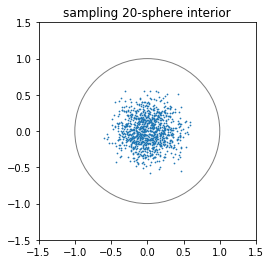

(1000, 20)


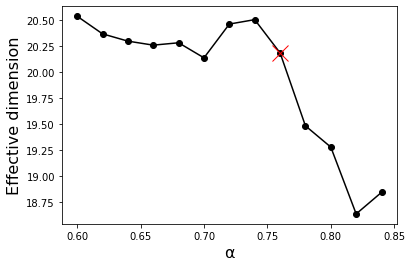

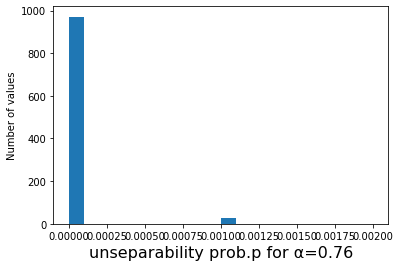

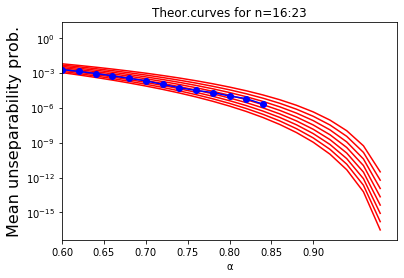

(20, 1000)


In [10]:
fig1 = plt.figure()
ax1 = fig1.gca()
npoints = 1000
dimension = 20
radius = 1
X,center = randsphere(npoints,dimension,radius)

ax1.scatter(X[:,0],X[:,1],s=0.5)
ax1.add_artist(plt.Circle(center,radius,fill=False,color='0.5'))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax1.set_aspect('equal')
ax1.set_title('sampling %i-sphere interior'%dimension)
plt.show()

print(X.shape)
[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(X)
#[n_alpha,n_single,p_alpha,retained_dim] = SeparabilityAnalysis_matlab(X)
print(p_alpha.shape)

# Work with BCNN data
### Loading a dataset

In [11]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive
#folder = '/gdrive/My Drive/Kharchenko_BCNN/'
#file = 'Sst.txt'

load_all = False

folder = '/home/utilisateur/Kharchenko_BCNN-20191205T143207Z-001/Kharchenko_BCNN/'

if not load_all:
    file = 'Sst.txt'
    df = pd.read_csv(folder+'bytype/'+file,sep='\t')
    #df = pd.read_csv(folder+file,sep='\t')
    #print(df)
    dft = df.transpose()
    #print(dft)
    list_of_samples = df.columns[1:-1].to_list()
    print('Number of columns = {}'.format(len(list_of_samples)))
    #x = df.to_numpy()[:,1:]
    # this is to treat an artefact of last empty column if needed
    x = df.to_numpy()[:,1:-1]
    x = x.T
else:
    file = 'pca.txt'
    df = pd.read_csv(folder+file,sep='\t')
    list_of_samples = df.SAMPLE[1:].to_list()
    #print(list_of_samples)
    print('Number of samples = {}'.format(len(list_of_samples)))
    x = df.to_numpy()[:,1:]

print(x.shape)
print(x)

annot_file = 'clusterings5.txt'
annot_df = pd.read_csv(folder+annot_file,sep='\t')
print(annot_df)
samplesAnn = annot_df['SAMPLE'].tolist()
print('Number of samples = {}'.format(len(samplesAnn)))
samplesAnnDict = list2dict(samplesAnn)

irx = ismember(list_of_samples,samplesAnnDict)
clusters =  annot_df.loc[irx,'CLUSTER'].tolist()
unique_clusters = list(set(clusters))

cluster_counts = []
for s in unique_clusters:
    cluster_counts.append(clusters.count(s))
big_clusters = []
for i,s in enumerate(unique_clusters):
    print(str(s)+' {}'.format(cluster_counts[i]))
    if cluster_counts[i]>100:
        big_clusters.append(s)

print(big_clusters)

Number of columns = 2335
(2335, 50)
[[23.041 1.909 1.547 ... -2.369 1.89 6.86]
 [19.537 0.7609999999999999 0.426 ... -0.98 0.807 3.366]
 [18.512 2.0540000000000003 -0.5 ... -2.33 -0.6709999999999999 2.785]
 ...
 [22.570999999999998 -2.4819999999999998 0.479 ... 1.7369999999999999
  2.76 -12.773]
 [23.78 -2.767 1.79 ... 2.633 0.795 -10.538]
 [23.485 -2.3480000000000003 -0.267 ... 1.3730000000000002 2.032 -9.7]]
                                     SAMPLE  CLUSTER
0      AAACCTGAGGGCTCTC-4L8TX_171026_01_F04        3
1      AAACCTGCAAGGACAC-4L8TX_171026_01_F04        1
2      AAACCTGCAATTCCTT-4L8TX_171026_01_F04       59
3      AAACCTGCAGTCGATT-4L8TX_171026_01_F04       40
4      AAACCTGCATGTAAGA-4L8TX_171026_01_F04       49
...                                     ...      ...
35830  TTTGTCATCACGGTTA-8L8TX_171026_01_A05       28
35831  TTTGTCATCGGTCTAA-8L8TX_171026_01_A05        6
35832  TTTGTCATCTCCCTGA-8L8TX_171026_01_A05       20
35833  TTTGTCATCTGAGTGT-8L8TX_171026_01_A05       44
358

### Computing PCA

Computing PCA...
(2335, 50)
 Elapsed time 0.01 s


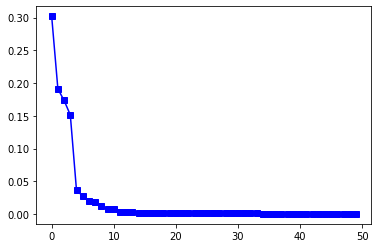

In [12]:
pca = PCA()
print('Computing PCA...')
start_time = time.time()
pcs = pca.fit_transform(x)
print(pcs.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))
ev = pca.explained_variance_ratio_

plt.figure(0)
plt.plot(ev,'bs-')
plt.show()

### Computing UMAP and tSNE embeddings 

In [13]:
knn = max(5,int(x.shape[0]/20))
knn = 20
reducer = umap.UMAP(n_neighbors=knn)
print('Computing UMAP...')
start_time = time.time()
umap_emb = reducer.fit_transform(x)
print(umap_emb.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))

print('Computing tSNE...')
start_time = time.time()
tsne_emb = TSNE(n_components=2).fit_transform(x)
print(tsne_emb.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))

Computing UMAP...
(2335, 2)
 Elapsed time 11.35 s
Computing tSNE...
(2335, 2)
 Elapsed time 16.93 s


### Plotting by classes 

NameError: name 'trimap_emb' is not defined

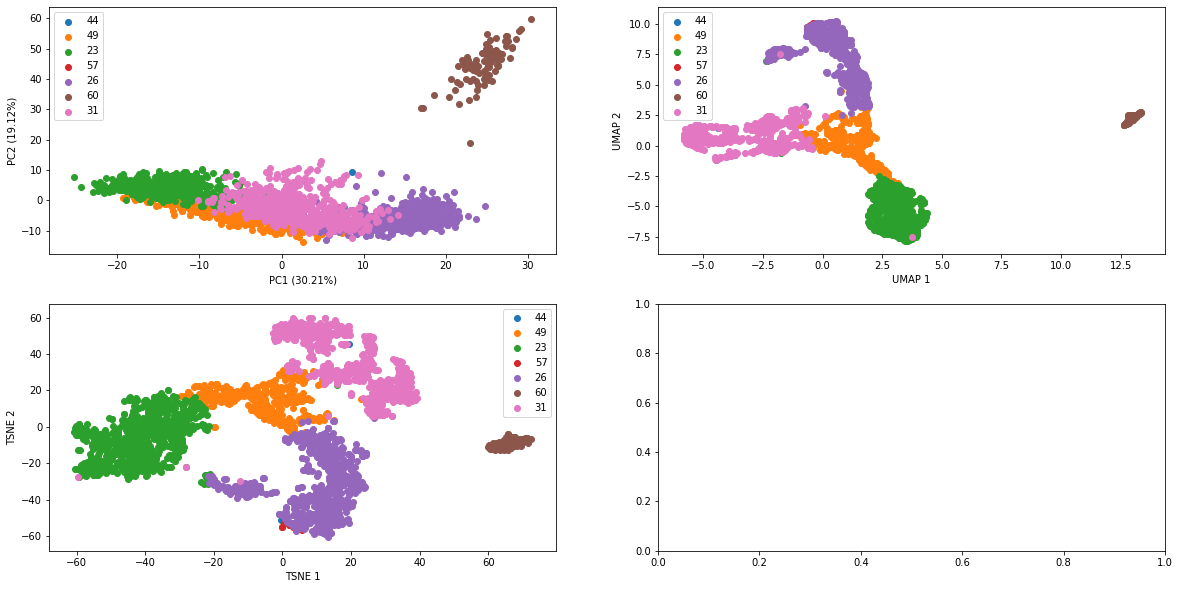

In [14]:
colors = ['red','green','blue','maroon','magenta','lime','skyblue','darkgrey','black','gold','purple']
c = []
for i in range(1,1000):
    for j in range(1,len(colors)):
        c.append(colors[j])
colors = c
labels = ['']*len(unique_clusters)
for i,s in enumerate(unique_clusters):
    labels[i] = str(s)

plt.figure(figsize=(20,10))
# PCA
plt.subplot(221)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(pcs[irx,0],pcs[irx,1])
plt.legend(labels)    
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)

# UMAP
plt.subplot(222)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(umap_emb[irx,0],umap_emb[irx,1])
plt.legend(labels)    
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)

# TSNE
plt.subplot(223)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1])
plt.legend(labels)    
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)


# TRIMAP
plt.subplot(224)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(trimap_emb[irx,0],trimap_emb[irx,1])
plt.legend(labels)    
plt.xlabel('TRIMAP 1', fontsize = 10)
plt.ylabel('TRIMAP 2', fontsize = 10)

plt.show()

## Global estimates
### Separability analysis

Elapsed time = 0.0003504753112792969
12 components are retained using factor 100.00


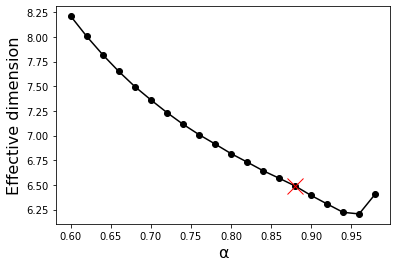

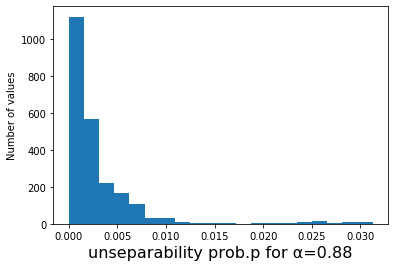

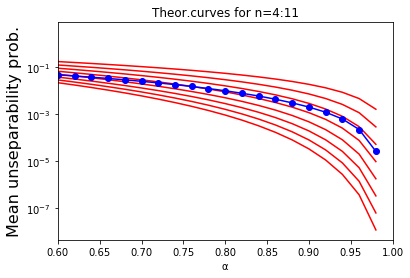

In [16]:
ConditionalNumber = 100

start_time = time.time()
#[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(x.astype(np.float64),ConditionalNumber=ConditionalNumber,ncomp=1)
print("Elapsed time = {}".format(time.time()-start_time))

# Decide the retained dimension for further analysis
#Retained_dimension = Xp.shape[1]
Retained_dimension = 12

# Retain the selected number of components
pca = PCA()
u = pca.fit_transform(x)
x_projected = u[:,0:Retained_dimension]

[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(x_projected,ConditionalNumber=100,ncomp=1)

In [19]:
fisher = n_single[0]
ess = intdim.essLocalDimEst(x_projected, ver = 'a', d = 1)[0][0]
mle = ider.lbmle(x_projected, p = x_projected.shape[1], DM = False)[0]
mle_global = intdim.maxLikGlobalDimEst(x_projected,k=30)[0][0]
geo_mle = geomle.geomle(pd.DataFrame(x_projected)).mean()
nni =  np.array(ider.nni(x_projected,DM = False, eps = 0.01, p = x_projected.shape[1]))[0]
pack = np.array(ider.pack(x_projected,greedy = True, eps = 0.01,DM = False))[0]
pca = np.array(intdim.pcaLocalDimEst(x_projected,ver='fan'))[0][0]
mada = ider.mada(x_projected,k=50, maxDim=x_projected.shape[1])[0]
corint = ider.corint(x_projected, DM = False, p = x_projected.shape[1])[0]
danco = runDANCo(x_projected,k=10)[0]
twonn = TwoNN(x_projected)
anova = runANOVAglobal(x_projected)[0,0]

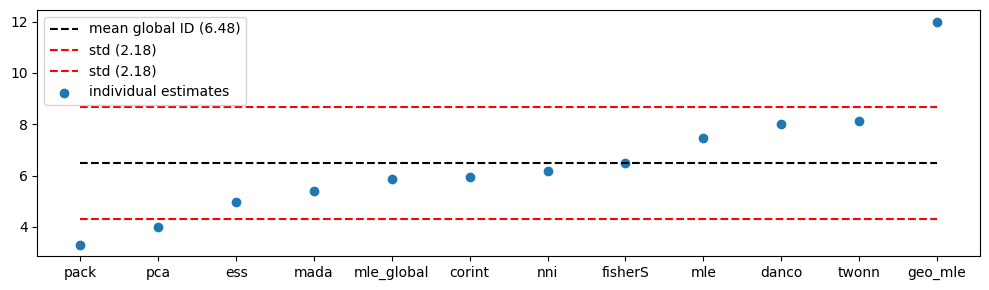

In [213]:
#estimates
names = np.array(['fisherS','ess','danco','twonn','corint','mle','mle_global','geo_mle','nni','pack','pca','mada'])
global_estimates = np.array([fisher,ess,danco,twonn,corint,mle,mle_global,geo_mle.mean(),nni,pack,pca,mada])

#basic stats
mean_id = global_estimates.mean()
sd_id = global_estimates.std()

#optional sorting by increasing ID
sort_idx = global_estimates.argsort()
global_estimates = global_estimates[sort_idx]
names = names[sort_idx]

#plot
plt.figure(figsize=(10,3))
plt.scatter(list(range(len(global_estimates))),global_estimates,label='individual estimates')
plt.plot(list(range(len(global_estimates))),[mean_id]*len(global_estimates),'--', c='black',label='mean global ID ({})'.format(round(mean_id,2)))
plt.plot(list(range(len(global_estimates))),[mean_id+sd_id]*len(global_estimates),'--', c='red',label='std ({})'.format(round(sd_id,2)))
plt.plot(list(range(len(global_estimates))),[mean_id-sd_id]*len(global_estimates),'--', c='red',label='std ({})'.format(round(sd_id,2)))
plt.xticks(list(range(len(global_estimates))),names)
plt.legend()
plt.tight_layout()
plt.show()

#### FisherS study : filtering by the separability distribution

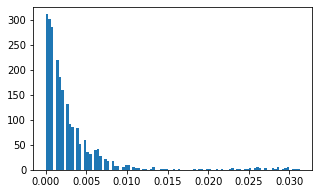

In [23]:
# plotting the separability distribution
alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]
#print(palpha_selected,alpha_index)

plt.figure(figsize=(5,3))
plt.hist(palpha_selected,bins=100)
plt.show()

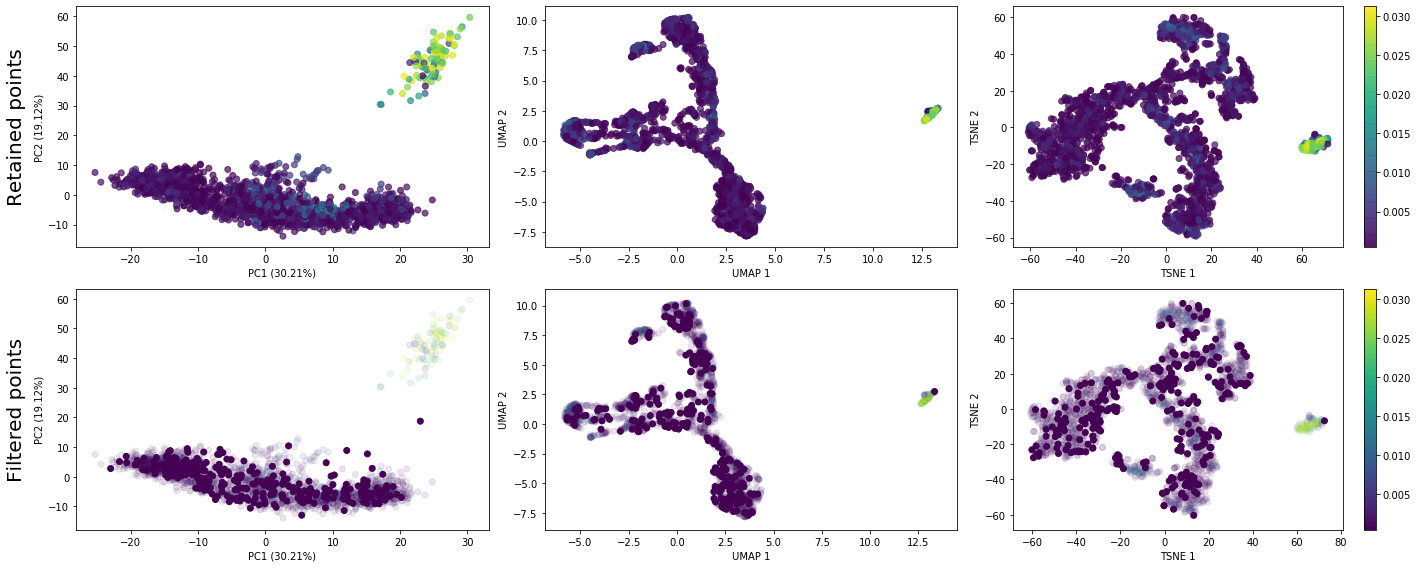

In [71]:
# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*.05
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]
not_irx = [i for i, n in enumerate(palpha_selected) if (n < threshold)]

# plotting retained, filtered data
c=p_alpha[alpha_index,irx]
c2=p_alpha[alpha_index,not_irx]

alpha_retained = .7
#c= [clusters[i] for i in irx]
plt.figure(figsize=(20,8))
plt.subplot(231)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c,alpha=alpha_retained)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.annotate('Retained points', (0, 0.5), xytext=(-50, 0), ha='right', va='center',
                    size=20, rotation=90, xycoords='axes fraction',textcoords='offset points')
plt.subplot(232)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c,alpha=alpha_retained)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)

plt.subplot(233)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c,alpha=alpha_retained)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.subplot(234)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c,alpha=.1)
plt.scatter(pcs[not_irx,0],pcs[not_irx,1],c=c2,vmin=c.min(), vmax=c.max())
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.annotate('Filtered points', (0, 0.5), xytext=(-50, 0), ha='right', va='center',
                    size=20, rotation=90, xycoords='axes fraction',textcoords='offset points')
plt.subplot(235)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c,alpha=.1)
plt.scatter(umap_emb[not_irx,0],umap_emb[not_irx,1],c=c2,vmin=c.min(), vmax=c.max())
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)

plt.subplot(236)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c,alpha=.1)
cbar = plt.colorbar()
cbar.solids.set(alpha=1)
plt.scatter(tsne_emb[not_irx,0],tsne_emb[not_irx,1],c=c2,vmin=c.min(), vmax=c.max())
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)

plt.tight_layout()
plt.show()

## Pointwise estimates
#### Compute pointwise ID

In [43]:
n_neighbors = 100

fisherS_pw = asPointwise(x_projected, SeparabilityAnalysis, params = dict(ProducePlots=0), n_neighbors=n_neighbors)
fisherS_pw = [i[1][0] for i in fisherS_pw]

ess_pw = asPointwise(x_projected,intdim.essLocalDimEst, params = dict(ver='a',d=1),n_neighbors=n_neighbors)
ess_pw = [i[0][0] for i in ess_pw]

corint_pw = asPointwise(x_projected,ider.corint, params = dict(p = x_projected.shape[1]), n_neighbors=n_neighbors)
corint_pw = [i[0] for i in corint_pw]

twonn_pw = asPointwise(x_projected,TwoNN, params = dict(filename='data.txt'),n_neighbors=n_neighbors)
danco_pw = runDANColoop(x_projected,k=n_neighbors)
anova_pw = runANOVA(x_projected)[:,0]

rado_ests = radovanovic_estimators_matlab(x_projected,k=n_neighbors)
mle_pw, tle_pw, mom_pw, ed_pw, ged_pw, lpca_pw = rado_ests.values()

r_mle_pw = intdim.maxLikPointwiseDimEst(x_projected,k=n_neighbors)
r_mle_pw = np.array([i[0] for i in r_mle_pw])

#### Plot pointwise ID

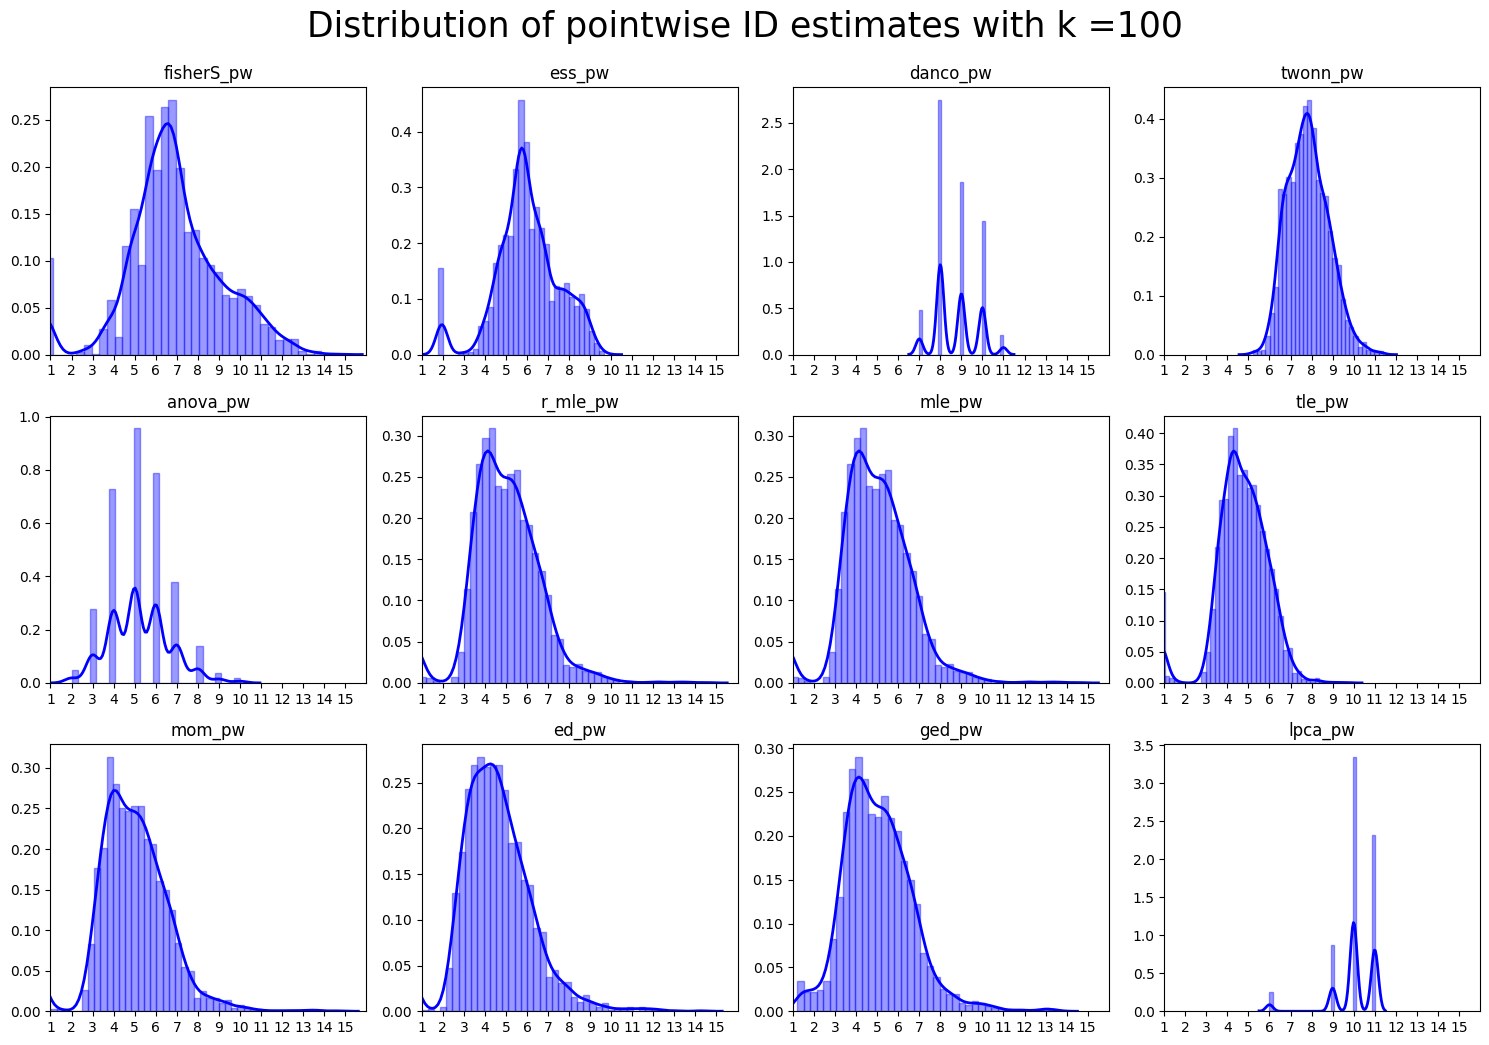

In [223]:
#estimates
ests_pw = np.array([fisherS_pw, ess_pw, danco_pw, twonn_pw, anova_pw, r_mle_pw, mle_pw, tle_pw, mom_pw, ed_pw, ged_pw, lpca_pw])
ests_pw_names = ['fisherS_pw', 'ess_pw', 'danco_pw', 'twonn_pw', 'anova_pw', 'r_mle_pw', 'mle_pw', 'tle_pw', 'mom_pw', 'ed_pw', 'ged_pw', 'lpca_pw']

#plot distributions
plt.figure(figsize=(15,10))
plt.suptitle('Distribution of pointwise ID estimates with k ={}'.format(n_neighbors),y=1.04, fontsize=25)
xmin = max(1,int(np.min(ests_pw)-2))
xmax = int(np.max(ests_pw)+2)
for i,est in enumerate(ests_pw):
    plt.subplot(3,4,i+1)
    plt.title(ests_pw_names[i])
    sns.distplot(est, hist=True, kde=True, color = 'blue', 
                 hist_kws={'edgecolor':'blue'},
                 kde_kws={'linewidth': 2})
    plt.xlim(xmin,xmax)
    plt.xticks(list(range(int(xmin),int(xmax))))
plt.tight_layout()
plt.show()

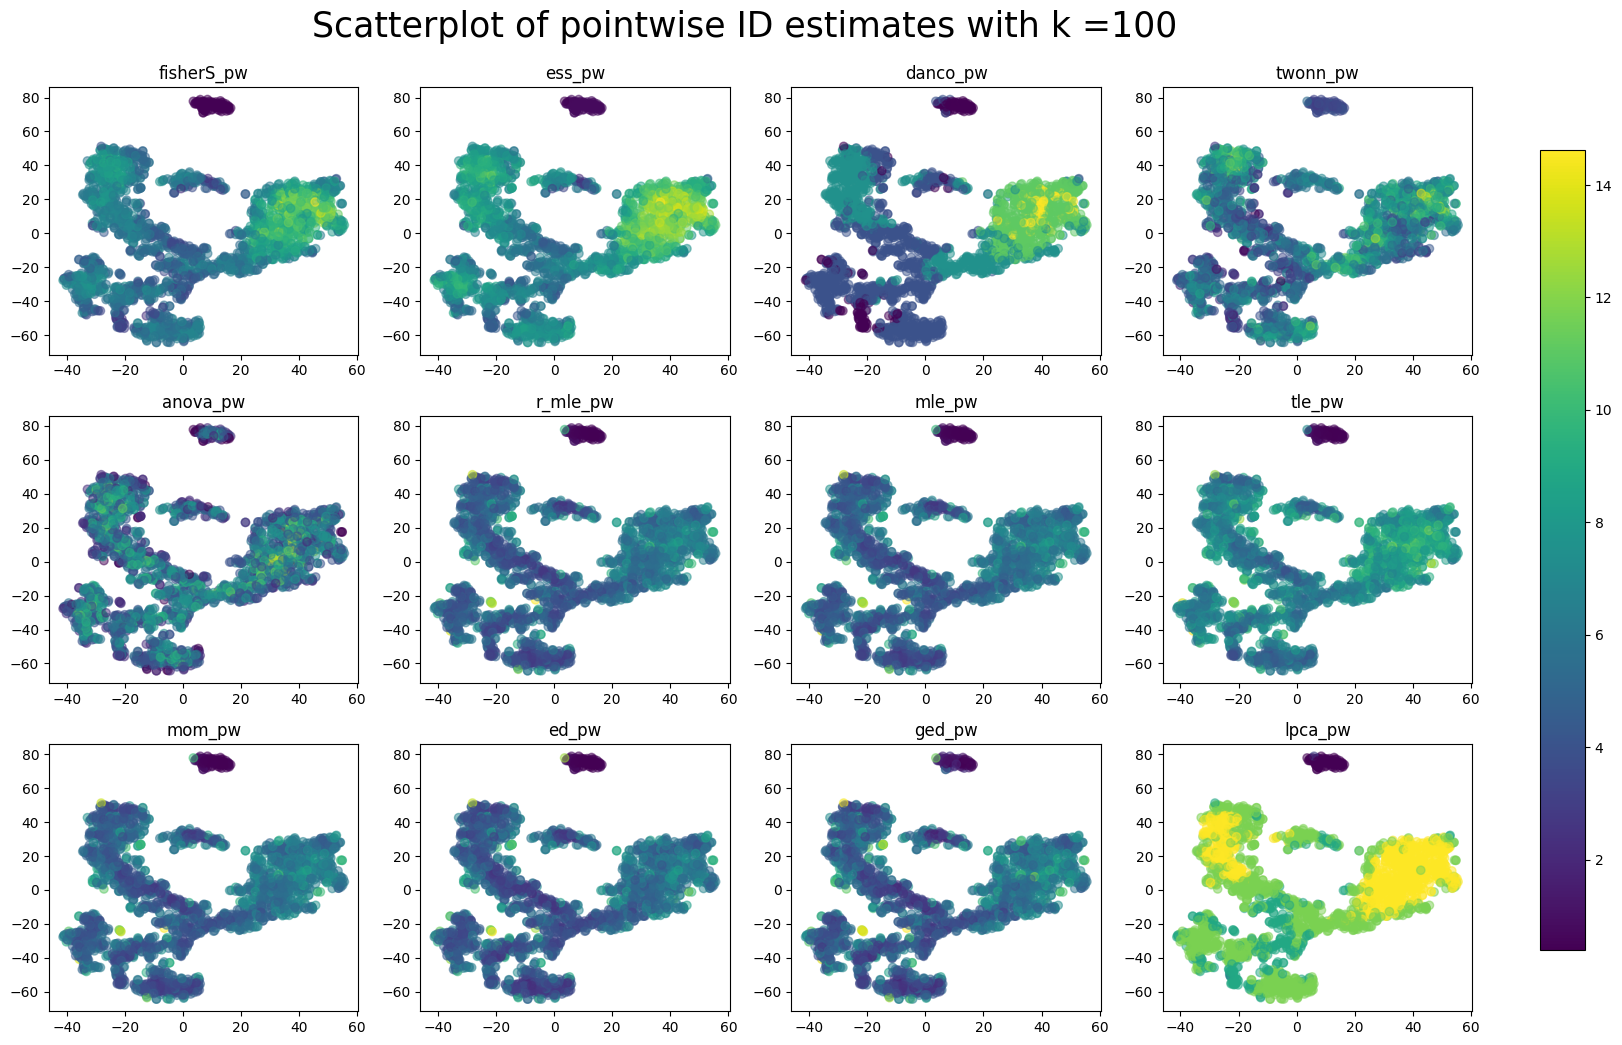

In [225]:
fig, axs = plt.subplots(3,4,figsize=(15,10))
axes = list(axs.flat)
plt.suptitle('Scatterplot of pointwise ID estimates with k ={}'.format(n_neighbors),y=1.04,fontsize=25)
for i,est in enumerate(ests_pw):
    axes[i].set_title(ests_pw_names[i])
    axes[i].scatter(tsne_emb[:,0],tsne_emb[:,1],c=est,alpha=.5)

xmin = np.min(ests_pw)
xmax = np.max(ests_pw)
cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=xmin,vmax=xmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbaxes = fig.add_axes([1.03, .1, .03, .8]) 
fig.colorbar(sm,ax=axs.ravel().tolist(),cax=cbaxes)
plt.tight_layout()
plt.show()

#### Clustering by local ID with TwoNN (Hidalgo)

In [13]:
hidalgo_clustering = Hidalgo(x_projected.astype(float),filename=path_to_package_folder+'/Hidalgo/')['Z'][0,0][0]

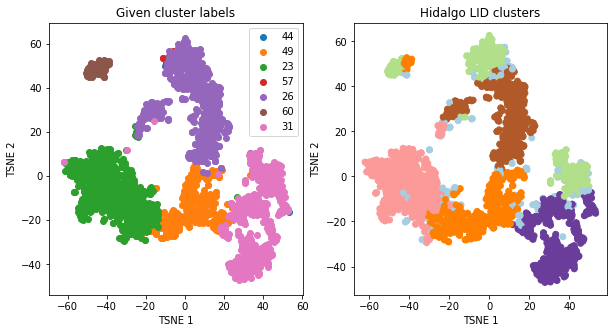

In [16]:
# TSNE
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Given cluster labels')
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1])
plt.legend(labels)    
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)

plt.subplot(122)
plt.title('Hidalgo LID clusters')
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=hidalgo_clustering,cmap=plt.cm.Paired)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)

plt.show()

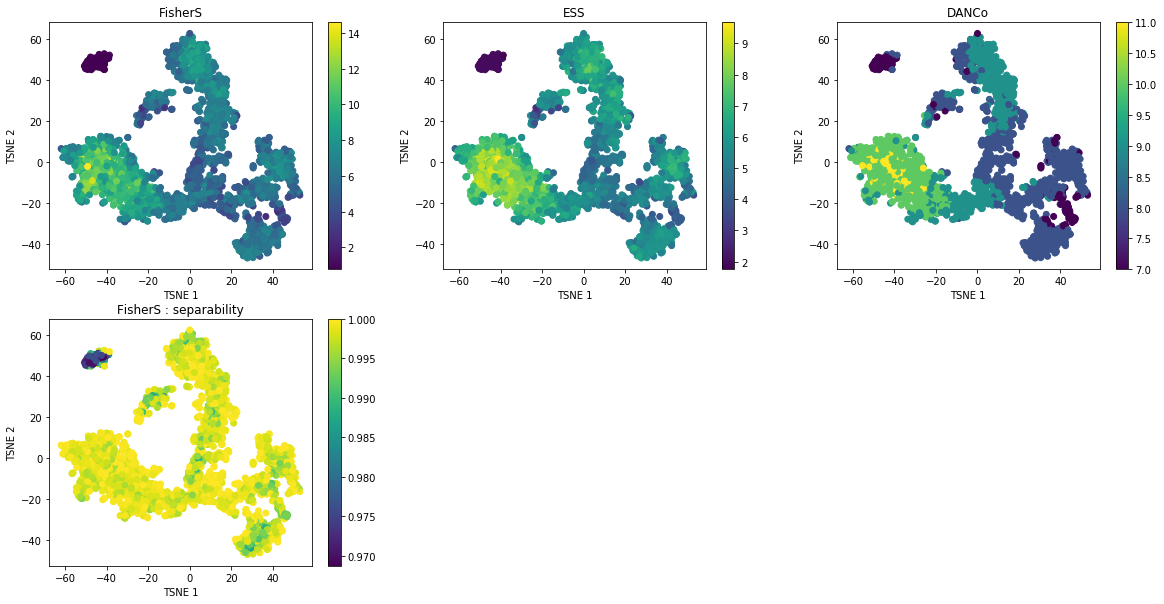

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title('FisherS')
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=fisherS_pw)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.subplot(232)
plt.title('ESS')
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=ess_pw)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.subplot(233)
plt.title('DANCo')
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=danco_pw)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.subplot(234)
plt.title('FisherS : separability')
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=1-p_alpha[alpha_index,:])
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()


plt.show()

In [20]:
pca = PCA()
u = pca.fit_transform(x)
x_projected = u[:,0:Retained_dimension]
print(x_projected.shape)

(2335, 12)


In [21]:
# testing separability saturation

n_samples = x.shape[0]
print('Number of sample = {}'.format(n_samples))

#sample_sizes = [2,5,7,10,15,20,25,30,40,50,60,70,80,90]
sample_sizes = [5,7,10,15,20,25,30,50,70,90]
#sample_sizes = [5,10,50]
sample_sizes_halves = [x/2 for x in sample_sizes]
all_sample_sizes = sample_sizes+sample_sizes_halves
all_sample_sizes = list(set(all_sample_sizes))
all_sample_sizes.sort()
n_repeats = 30

fisherS_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
pca_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
corint_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
mle_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
ess_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
danco_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
twonn_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])

print('Number of dimensions retained {}'.format(Retained_dimension))
x_proj = pcs[:,0:Retained_dimension]

for i,sz in enumerate(all_sample_sizes):
    sample_size = int(n_samples*sz/100)
    print('Sample size = {}'.format(sample_size))
    start_time = time.time()
    for j in range(0,n_repeats):
        sample = np.random.choice(n_samples,replace=False, size=sample_size)
        xs = x_proj[sample,:]
        
        #Run estimators
        [n_alpha_s,n_single_s,p_alpha_s,alphas_s,separable_fraction_s,Xp_s] = SeparabilityAnalysis(xs,ConditionalNumber=100000,ProducePlots=False)
        pca = np.array(intdim.pcaLocalDimEst(xs,ver='fan', alphaFO = 0.05, alphaFan = 10, betaFan = 0.8,PFan = 0.95, ngap = 5))[0][0]
        corint = ider.corint(xs,DM = False, p = xs.shape[1])[0]
        mle = ider.lbmle(xs,DM = False,p = xs.shape[1])[0]
        ess = intdim.essLocalDimEst(xs, ver = 'a', d = 1)[0][0]
        danco = runDANCo(xs,k=10)[0]
#         dancoR = intdim.dancoDimEst(xs,k=30,D=xs.shape[1])
        twonn = TwoNN(xs)
        
        #Store
        fisherS_dim_estimates[i,j] = n_single_s.astype(np.float64)
        pca_dim_estimates[i,j] = pca
        corint_dim_estimates[i,j] = corint
        mle_dim_estimates[i,j] = mle
        ess_dim_estimates[i,j] = ess
        danco_dim_estimates[i,j] = danco
        twonn_dim_estimates[i,j] = twonn

    print("Elapsed time = {}".format(time.time()-start_time))
        
[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(x_proj,ConditionalNumber=100000,ProducePlots=False)
pca = np.array(intdim.pcaLocalDimEst(x_proj,ver='fan', alphaFO = 0.05, alphaFan = 10, betaFan = 0.8,PFan = 0.95, ngap = 5))[0][0]
corint = ider.corint(x_proj,k1 = 2, k2 = 40, DM = False, p = False)[0]
mle = ider.lbmle(x_proj,k1 = 10, k2 = 40, BC = False, DM = False,p = [])[0]
ess = intdim.essLocalDimEst(x_proj, ver = 'a', d = 1)[0][0]
danco = runDANCo(x_proj,k=30)[0]
# dancoR = intdim.dancoDimEst(x_proj,k=30,D=xs.shape[1])

twonn = TwoNN(x_proj)
for i in range(0,n_repeats):
    fisherS_dim_estimates[len(all_sample_sizes),i] = n_single
    pca_dim_estimates[len(all_sample_sizes),i] = pca
    corint_dim_estimates[len(all_sample_sizes),i] = corint
    mle_dim_estimates[len(all_sample_sizes),i] = mle
    ess_dim_estimates[len(all_sample_sizes),i] = ess
    danco_dim_estimates[len(all_sample_sizes),i] = danco
    twonn_dim_estimates[len(all_sample_sizes),i] = twonn
    
all_sample_sizes.append(100)
sample_sizes.append(100)

np.savetxt("fisherS_dim_estimates.txt", fisherS_dim_estimates, delimiter="\t")
np.savetxt("pca_dim_estimates.txt", pca_dim_estimates, delimiter="\t")
np.savetxt("corint_dim_estimates.txt", corint_dim_estimates, delimiter="\t")
np.savetxt("mle_dim_estimates.txt", mle_dim_estimates, delimiter="\t")
np.savetxt("ess_dim_estimates.txt", ess_dim_estimates, delimiter="\t")
np.savetxt("danco_dim_estimates.txt", danco_dim_estimates, delimiter="\t")
np.savetxt("twonn_dim_estimates.txt", twonn_dim_estimates, delimiter="\t")

np.savetxt("all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
np.savetxt("sample_sizes.txt", sample_sizes, delimiter="\t")

Number of sample = 2335
Number of dimensions retained 12
Sample size = 58
Elapsed time = 2204.8269345760345
Sample size = 81
Elapsed time = 116.44132566452026
Sample size = 116
Elapsed time = 121.839271068573
Sample size = 163
Elapsed time = 136.52121424674988
Sample size = 175
Elapsed time = 134.55545115470886
Sample size = 233
Elapsed time = 122.58433699607849
Sample size = 291
Elapsed time = 125.71552753448486
Sample size = 350
Elapsed time = 125.77561092376709
Sample size = 467
Elapsed time = 125.28552770614624
Sample size = 583
Elapsed time = 136.4626247882843
Sample size = 700
Elapsed time = 147.32426047325134
Sample size = 817
Elapsed time = 157.30639934539795
Sample size = 1050
Elapsed time = 210.1407651901245
Sample size = 1167
Elapsed time = 224.69940948486328
Sample size = 1634
Elapsed time = 312.53573203086853
Sample size = 2101
Elapsed time = 392.40133023262024


fisherS_dim_estimates


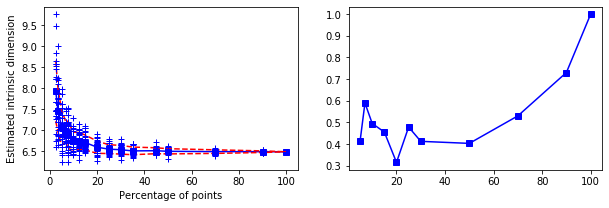

pca_dim_estimates


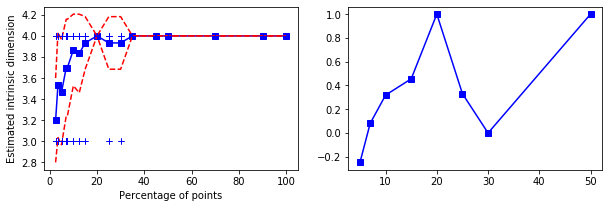

corint_dim_estimates


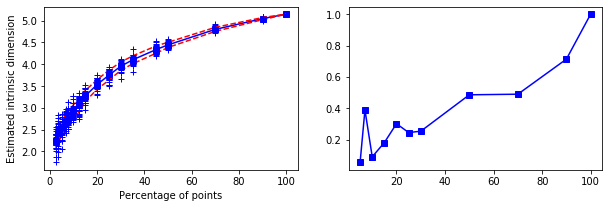

mle_dim_estimates


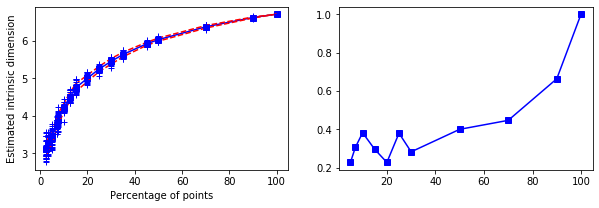

ess_dim_estimates


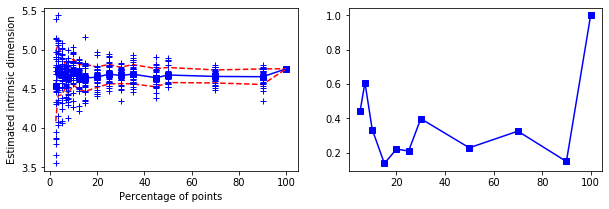

danco_dim_estimates


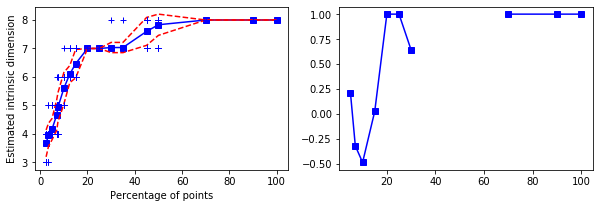

twonn_dim_estimates


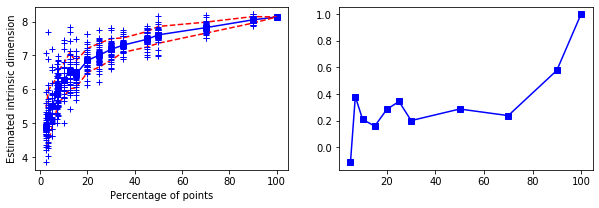

In [22]:
# plot convergence curve
alls=pd.read_csv('all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]
sizes=pd.read_csv('sample_sizes.txt', sep='\t',header=None)
sample_sizes =sizes.to_numpy()[:,0]

estimators = ['fisherS_dim_estimates','pca_dim_estimates','corint_dim_estimates','mle_dim_estimates','ess_dim_estimates','danco_dim_estimates','twonn_dim_estimates']
for estimator in estimators:
    print(estimator)
    ds=pd.read_csv(estimator+'.txt', sep='\t',header=None)
    dim_estimates=ds.to_numpy()

    #print(all_sample_sizes)
    #print(sample_sizes)

    #print(np.mean(dim_estimates[:,:],1).shape)
    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')
    #print(std)

    ratios = []
    for sz in sample_sizes:
        sz_half = sz/2
        k = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz-asz)<0.001 ][0]
        k_half = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz_half-asz)<0.001 ][0]
        #print(k,all_sample_sizes[k],k_half,all_sample_sizes[k_half])
        ratios.append(1-std[k]/std[k_half])

    plt.subplot(122)
    plt.plot(sample_sizes,ratios,'bs-')
    plt.show()

In [23]:
# random selection of clusters

number_of_repeats = 5
number_of_clusters = len(big_clusters)

print('Number of dimensions retained {}'.format(Retained_dimension))
x_proj = pcs[:,0:Retained_dimension]

fisherS_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
pca_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
corint_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
mle_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
ess_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
danco_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
twonn_dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
print(fisherS_dim_est_clusters.shape)

for nc in range(1,number_of_clusters):
    for reap in range(0,number_of_repeats):
        cluster_selection = random.sample(big_clusters, nc)
        irx = [i for i,cl in enumerate(clusters) if cl in cluster_selection]
        xsel = x_proj[irx,:]
        
        # Run estimators
        [n_alpha_s,n_single_s,p_alpha_s,alphas_s,separable_fraction_s,Xp_s] = SeparabilityAnalysis(xsel.astype(np.float64),ConditionalNumber=100000,ProducePlots=False)
        pca = np.array(intdim.pcaLocalDimEst(xsel.astype(np.float64),ver='fan', alphaFO = 0.05, alphaFan = 10, betaFan = 0.8,PFan = 0.95, ngap = 5))[0][0]
        corint = ider.corint(xsel.astype(np.float64),k1 = 2, k2 = 30, DM = False, p = False)[0]
        mle = ider.lbmle(xsel.astype(np.float64),k1 = 10, k2 = 20, BC = False, DM = False,p = [])[0]
        ess = intdim.essLocalDimEst(xsel.astype(np.float64), ver = 'a', d = 1)[0][0]
        danco = runDANCo(xsel.astype(np.float64),k=10)[0]
        twonn = TwoNN(xsel.astype(np.float64))
        
        #Store
        fisherS_dim_est_clusters[nc-1,reap] = n_single_s.astype(np.float64)
        pca_dim_est_clusters[nc-1,reap] = pca
        corint_dim_est_clusters[nc-1,reap] = corint
        mle_dim_est_clusters[nc-1,reap] = mle
        ess_dim_est_clusters[nc-1,reap] = ess
        danco_dim_est_clusters[nc-1,reap] = danco
        twonn_dim_est_clusters[nc-1,reap] = twonn
        
        print(nc,reap,n_single_s)
        #alpha_index = (n_alpha==n_single).tolist().index(True)
        #palpha_selected = p_alpha[alpha_index,:]
        #c=p_alpha[alpha_index,irx]
        #plt.scatter(xsel[:,0],xsel[:,1],c=c)
        #plt.show()
        
pca = np.array(intdim.pcaLocalDimEst(x_proj.astype(np.float64),ver='fan', alphaFO = 0.05, alphaFan = 10, betaFan = 0.8,PFan = 0.95, ngap = 5))[0][0]
corint = ider.corint(x_proj.astype(np.float64),k1 = 2, k2 = 30, DM = False, p = False)[0]
mle = ider.lbmle(x_proj.astype(np.float64),k1 = 10, k2 = 20, BC = False, DM = False,p = [])[0]
ess = intdim.essLocalDimEst(x_proj.astype(np.float64), ver = 'a', d = 1)[0][0]
danco = runDANCo(x_proj.astype(np.float64),k=10)[0]
twonn = TwoNN(x_proj.astype(np.float64))
for i in range(0,number_of_repeats):
    fisherS_dim_est_clusters[number_of_clusters-1,i] = n_single
    pca_dim_est_clusters[number_of_clusters-1,i] = pca
    corint_dim_est_clusters[number_of_clusters-1,i] = corint
    mle_dim_est_clusters[number_of_clusters-1,i] = mle
    ess_dim_est_clusters[number_of_clusters-1,i] = ess
    danco_dim_est_clusters[number_of_clusters-1,i] = danco
    twonn_dim_est_clusters[number_of_clusters-1,i] = twonn
print(fisherS_dim_est_clusters)

Number of dimensions retained 12
(4, 5)
1 0 [10.58450853]
1 1 [9.8328173]
1 2 [8.41265295]
1 3 [9.8328173]
1 4 [8.41265295]
2 0 [8.33505821]
2 1 [8.46829474]
2 2 [9.38135617]
2 3 [8.46829474]
2 4 [7.68982004]
3 0 [7.94069119]
3 1 [7.2079209]
3 2 [8.37023523]
3 3 [7.09390107]
3 4 [7.09390107]
[[10.58450853  9.8328173   8.41265295  9.8328173   8.41265295]
 [ 8.33505821  8.46829474  9.38135617  8.46829474  7.68982004]
 [ 7.94069119  7.2079209   8.37023523  7.09390107  7.09390107]
 [ 6.48927363  6.48927363  6.48927363  6.48927363  6.48927363]]


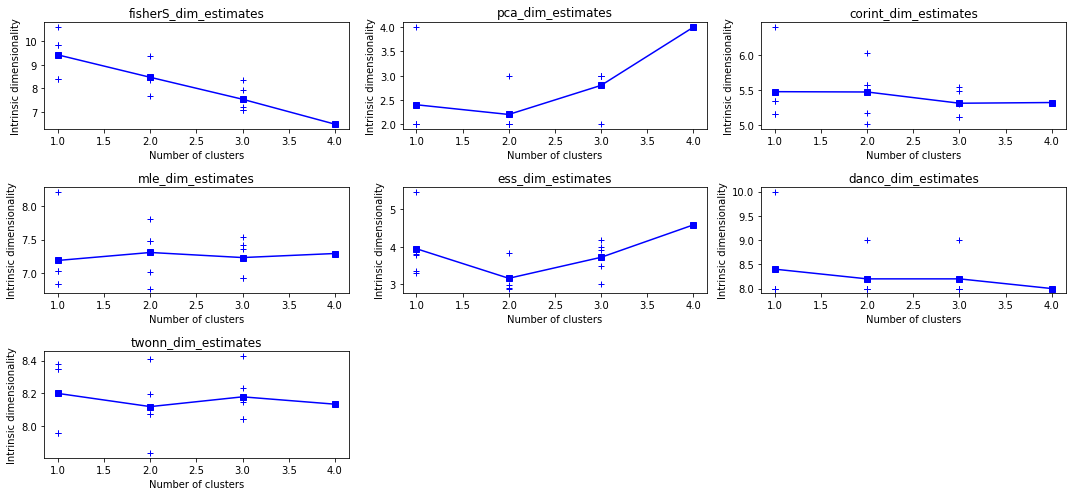

In [24]:
# plot dependence of ID vs number of clusters
all_estimators_dim_est_clusters = [fisherS_dim_est_clusters,pca_dim_est_clusters,corint_dim_est_clusters,mle_dim_est_clusters,ess_dim_est_clusters,danco_dim_est_clusters,twonn_dim_est_clusters]
plt.figure(figsize=(15,7))
for i,dim_est_clusters in enumerate(all_estimators_dim_est_clusters):
    plt.subplot(3,3,i+1)
    plt.title(estimators[i])
    plt.plot(range(1,number_of_clusters+1),dim_est_clusters,'b+')
    plt.plot(range(1,number_of_clusters+1),np.mean(dim_est_clusters,1),'bs-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Intrinsic dimensionality')
plt.tight_layout()
plt.show()

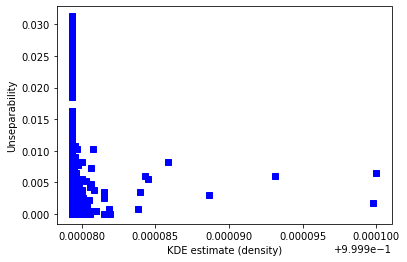

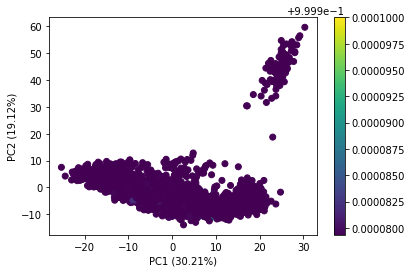

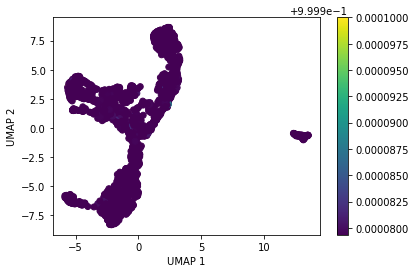

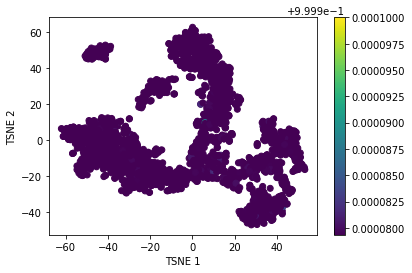

In [25]:
# compare separability with KDE density estimate

mu=np.array([1,10,20])
sigma=np.matrix([[4,10,0],[10,25,0],[0,0,100]])
data=np.random.multivariate_normal(mu,sigma,1000)
values = data.T

values = x.T
values = values.astype(np.float64)

kde = stats.gaussian_kde(values)
density = kde(values)
density = density/np.max(density)

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

plt.figure(0)
plt.plot(density,palpha_selected,'bs')
plt.xlabel('KDE estimate (density)')
plt.ylabel('Unseparability')
plt.show()

# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*0
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]
c=density[irx]
#c= [clusters[i] for i in irx]

plt.figure(0)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.colorbar()

plt.figure(1)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)
plt.colorbar()

plt.figure(2)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.show()